Defining an "*adopted user*"  as a user who has logged into the product on three separate days in at least one seven-day period, **identify which factors predict future user adoption.**

We suggest spending 1-2 hours on this, but you're welcome to spend more or less. Please send us a brief writeup of your findings (the more concise, the better -- no more than one page), along with any summary tables, graphs, code, or queries that can help us understand your approach. Please note any factors you considered or investigation you did, even if they did not pan out. Feel free to identify any further research or data you think would be valuable.

# Load Packages

In [2]:
import datetime as dt
from datetime import timedelta

import json
from mizani.formatters import * # this has various scales
import numpy as np
import pandas as pd
from plotnine import *
import plotnine
import plydata.cat_tools as cat
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
#from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, precision_recall_curve, auc
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.tree import DecisionTreeClassifier
import warnings

plotnine.options.figure_size = (20, 10)
warnings.filterwarnings("ignore")

# Load Data

In [6]:
users_df = pd.read_csv("takehome_users.csv", encoding = "latin-1")

users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


## Metadata
* **name:** the  user's  name
* **object_id:** the  user's  id
* **email:** email  address
* **creation_source:** how  their  account  was  created.  This  takes  on  one of  5  values:
    * **PERSONAL_PROJECTS:**  invited  to  join  another  user's personal  workspace
    * **GUEST_INVITE:**  invited  to  an  organization  as  a  guest (limited  permissions)
    * **ORG_INVITE:** invited  to  an  organization  (as  a  full  member)
    * **SIGNUP:** signed  up  via  the  website
    * **SIGNUP_GOOGLE_AUTH:** signed  up  using  Google Authentication (using  a  Google  email  account  for  their  login id)
* **creation_time:** when  they  created  their  account
* **last_session_creation_time:** unix  timestamp  of  last  login
* **opted_in_to_mailing_list:** whether  they  have  opted  into  receiving marketing  emails
* **enabled_for_marketing_drip:** whether  they  are  on  the  regular marketing  email  drip
* **org_id:** the  organization  (group  of  users)  they  belong  to
* **invited_by_user_id:**  which  user  invited  them  to  join  (if  applicable).

The following columns don't look useful in predicting user adoption so they will be removed

name, email, org_id, invited_by_user_id

It is possible one of these may have a strong correlation to user adoption, but I that would be random chance and would get in the way of serious insights. 

I will also change the creation_time and last_session_creation_time to datetime and use that to create a new variable for the number of days an account was active.

In [7]:
users_df = users_df.assign(creation_time = lambda x: pd.to_datetime(x.creation_time), 
                           last_session_creation_time = lambda x: pd.to_datetime(x.last_session_creation_time.astype("Int64"), unit = "s"), 
                           account_days = lambda x: (x.last_session_creation_time - x.creation_time).dt.days.astype("Int64").fillna(0), 
                           email = lambda x: x.email.str.split('@').str[1], 
                           invited_by_user_id = lambda x: x.invited_by_user_id.fillna(0)).\
drop(columns = ["name", "email", "org_id", "invited_by_user_id"])

users_df.head()

## hese lines were used to convert the plethora of low frequency email domains to "Other" but is no longer needed
# top_emails = pd.DataFrame(users_df.email.value_counts()).query("email > 2").index.tolist()
# users_df = users_df.assign(email = lambda x: np.where(x.email.isin(top_emails), x.email, "Other"))


,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,account_days
0,1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,0
1,2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,136
2,3,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0,0
3,4,2013-05-21 08:09:28,GUEST_INVITE,2013-05-22 08:09:28,0,0,1
4,5,2013-01-17 10:14:20,GUEST_INVITE,2013-01-22 10:14:20,0,0,5


In [8]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   creation_source             12000 non-null  object        
 3   last_session_creation_time  8823 non-null   datetime64[ns]
 4   opted_in_to_mailing_list    12000 non-null  int64         
 5   enabled_for_marketing_drip  12000 non-null  int64         
 6   account_days                12000 non-null  Int64         
dtypes: Int64(1), datetime64[ns](2), int64(3), object(1)
memory usage: 668.1+ KB


# Find Adopted Users

Define an "*adopted user*" as a user who has logged into the product on three separate days in at least one seven-day period.

In [11]:
# Load the data
# Convert timestamp to datetime
# SImplify it to just the date as the time of day is not needed
engagement_df = pd.read_csv("takehome_user_engagement.csv").\
assign(time_stamp = lambda x: pd.to_datetime(x.time_stamp),
       date = lambda x: x.time_stamp.dt.date).\
set_index("time_stamp", drop = True)

engagement_df.head()

,user_id,visited,date
time_stamp,,,
2014-04-22 03:53:30,1,1,2014-04-22
2013-11-15 03:45:04,2,1,2013-11-15
2013-11-29 03:45:04,2,1,2013-11-29
2013-12-09 03:45:04,2,1,2013-12-09
2013-12-25 03:45:04,2,1,2013-12-25


In [13]:
def is_adopted(x):    
    
    df_temp = engagement_df.query("user_id == @x") # filter to individual user
    df_temp = df_temp.drop_duplicates(subset = "date").sort_values("date") # drop duplicate days
    adopted = 0 # set baseline for adopted
    
    for i in range(len(df_temp)-2): # loop over active days till the second to last day
        if df_temp.index[i + 2] - df_temp.index[i] <= timedelta(days=7): # difference between every 1st and 3rd day
            adopted = 1 # if True, change adopted to 1 isntead of 0 and
            break # end the loop to save time
            
    return adopted

users_df = users_df.assign(adoption = lambda x: x.object_id.apply(is_adopted)).\
set_index("object_id")

users_df

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,account_days,adoption
object_id,,,,,,,
1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,0,0
2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,136,1
3,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0,0,0
4,2013-05-21 08:09:28,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,0
5,2013-01-17 10:14:20,GUEST_INVITE,2013-01-22 10:14:20,0,0,5,0
...,...,...,...,...,...,...,...
11996,2013-09-06 06:14:15,ORG_INVITE,2013-09-06 06:14:15,0,0,0,0
11997,2013-01-10 18:28:37,SIGNUP_GOOGLE_AUTH,2013-01-15 18:28:37,0,0,5,0
11998,2014-04-27 12:45:16,GUEST_INVITE,2014-04-27 12:45:16,1,1,0,0


# Exploratory Data Analysis

In [14]:
# Thes columns are no longer needed
users_df = users_df.drop(columns = ["creation_time", "last_session_creation_time"])

users_df.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,account_days,adoption
object_id,,,,,
1,GUEST_INVITE,1,0,0,0
2,ORG_INVITE,0,0,136,1
3,ORG_INVITE,0,0,0,0
4,GUEST_INVITE,0,0,1,0
5,GUEST_INVITE,0,0,5,0


First I'll check the distribution of adopted users with the newly created **adoption** variable

In [15]:
print(str(sum(users_df.adoption)) + " Adopted Users (" + percent_format()([sum(users_df.adoption)/len(users_df.adoption)])[0] + ")")

1656 Adopted Users (13.8%)


## Creation Source

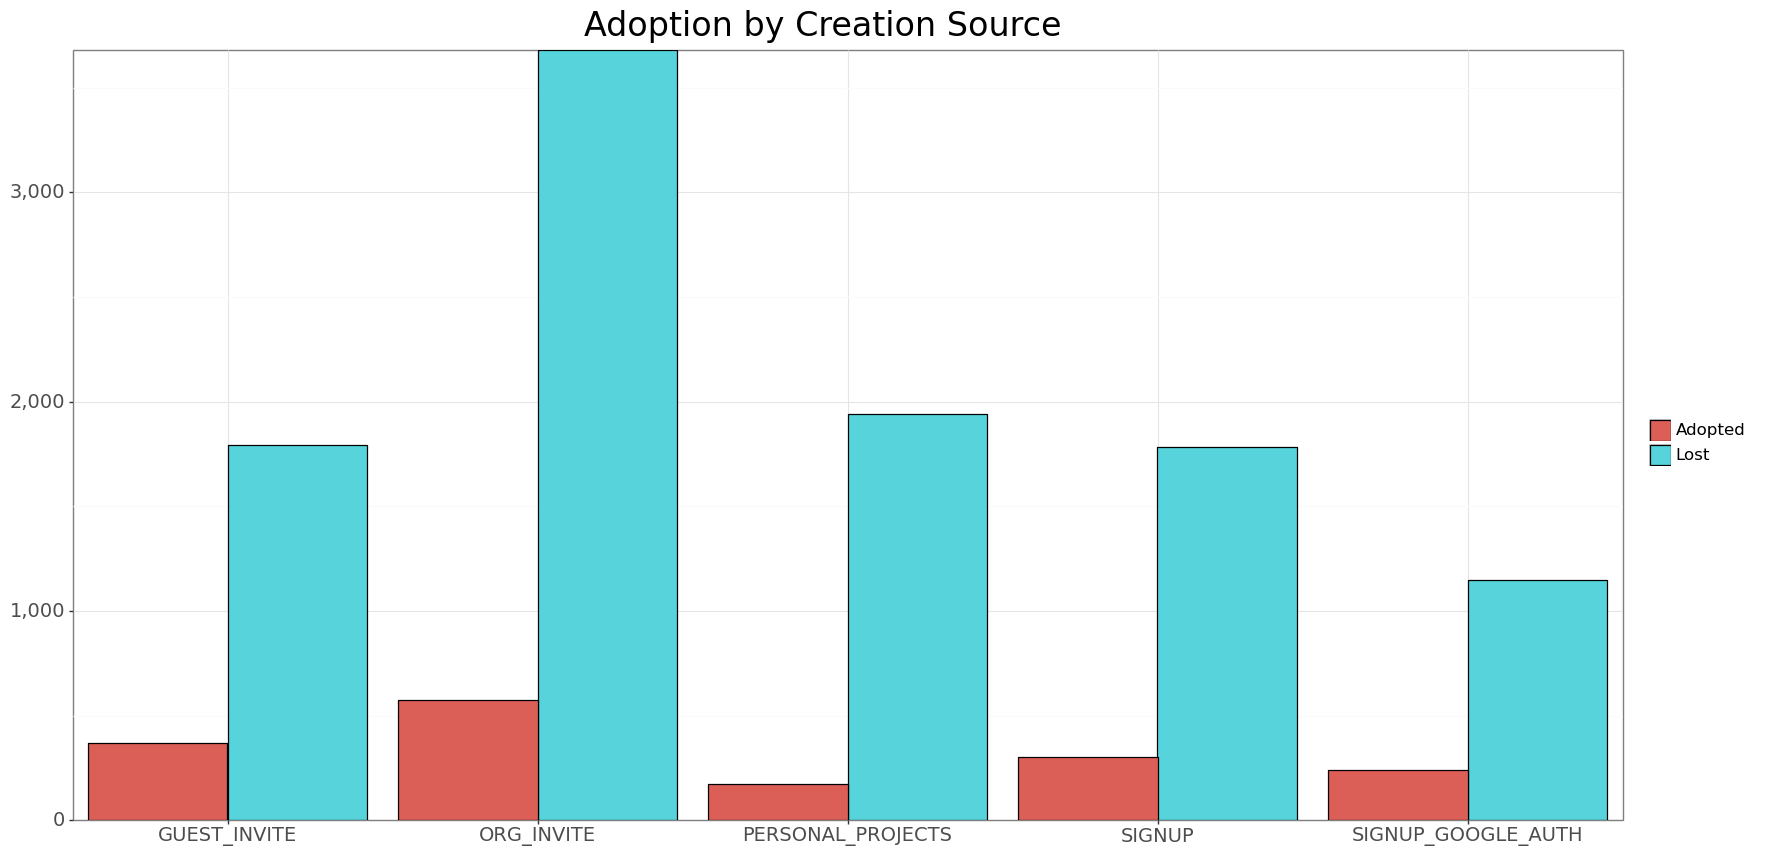

<ggplot: (102344948484)>

In [115]:
creation_source_df = pd.DataFrame(users_df[["adoption", "creation_source"]].value_counts()).\
reset_index().\
assign(adoption = lambda x: x.adoption.apply(lambda y: "Adopted" if y == 1 else "Lost")).\
rename(columns = {0 : "count"})

(ggplot(creation_source_df, aes(x = "creation_source", y = "count", fill = "adoption")) + 
 geom_bar(stat = "identity", position = "dodge", color = "black") + 
 scale_x_discrete(expand = [.1,  .1]) + 
 scale_y_continuous(labels = comma_format(), expand = [0, 0]) +
 labs(title = "Adoption by Creation Source", 
     x = "", 
     y = "", 
     fill = "") + 
 theme_bw() + 
 theme(axis_text_x = element_text(size = 14), 
       axis_text_y = element_text(size = 14), 
       legend_text = element_text(size = 12), 
       legend_title = element_text(size = 14), 
       plot_title = element_text(size = 24)))

Adoption rates split by creation source don't look drastically different. ORRG_INVITE has about twice as many lost users as the next group (GUEST_INVITE), but it also has the most adopted users as well.

## Mailing List

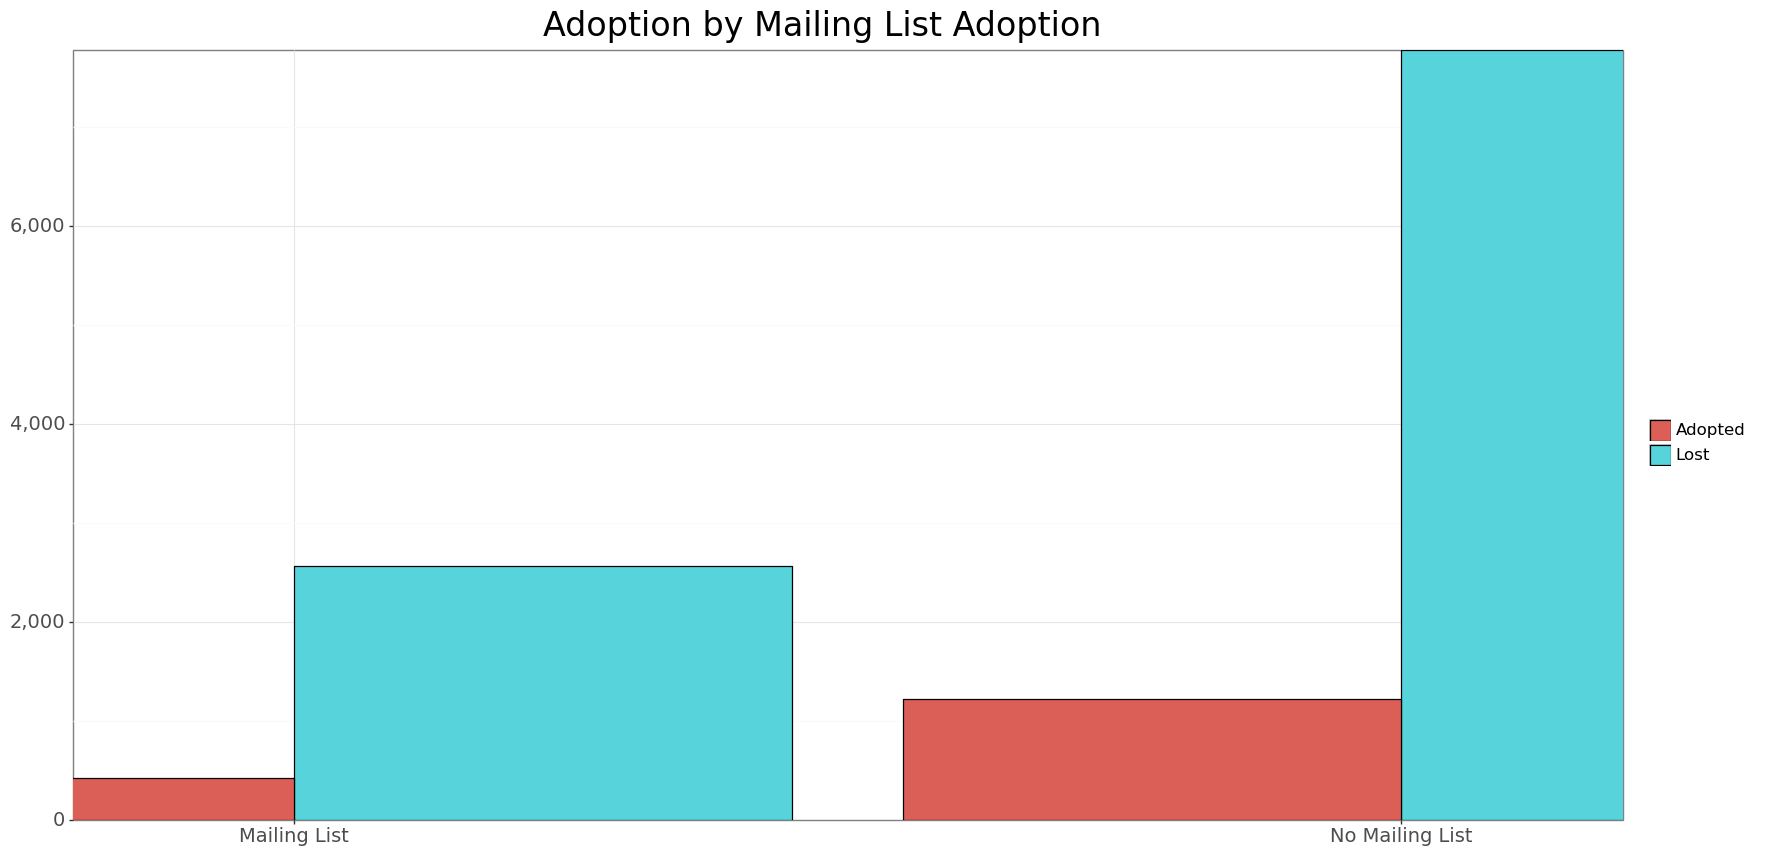

<ggplot: (132598756066)>

In [16]:
mailing_df =  pd.DataFrame(users_df[["adoption", "opted_in_to_mailing_list"]].value_counts()).\
reset_index().\
assign(adoption = lambda x: x.adoption.apply(lambda y: "Adopted" if y == 1 else "Lost"), 
       opted_in_to_mailing_list = lambda x: x.opted_in_to_mailing_list.apply(lambda y: "Mailing List" if y == 1 else "No Mailing List")).\
rename(columns = {0 : "count"})

(ggplot(mailing_df, aes(x = "opted_in_to_mailing_list", y = "count", fill = "adoption")) + 
 geom_bar(stat = "identity", position = "dodge", color = "black") + 
 scale_x_discrete(expand = [.1,  .1]) + 
 scale_y_continuous(labels = comma_format(), expand = [0, 0]) +
 labs(title = "Adoption by Mailing List Adoption", 
     x = "", 
     y = "", 
     fill = "") + 
 theme_bw() + 
 theme(axis_text_x = element_text(size = 14), 
       axis_text_y = element_text(size = 14), 
       legend_text = element_text(size = 12), 
       legend_title = element_text(size = 14), 
       plot_title = element_text(size = 24)))

Adoption rates look about the same regardless of whether or not the user signed up for the mailing list

## Marketing Drip

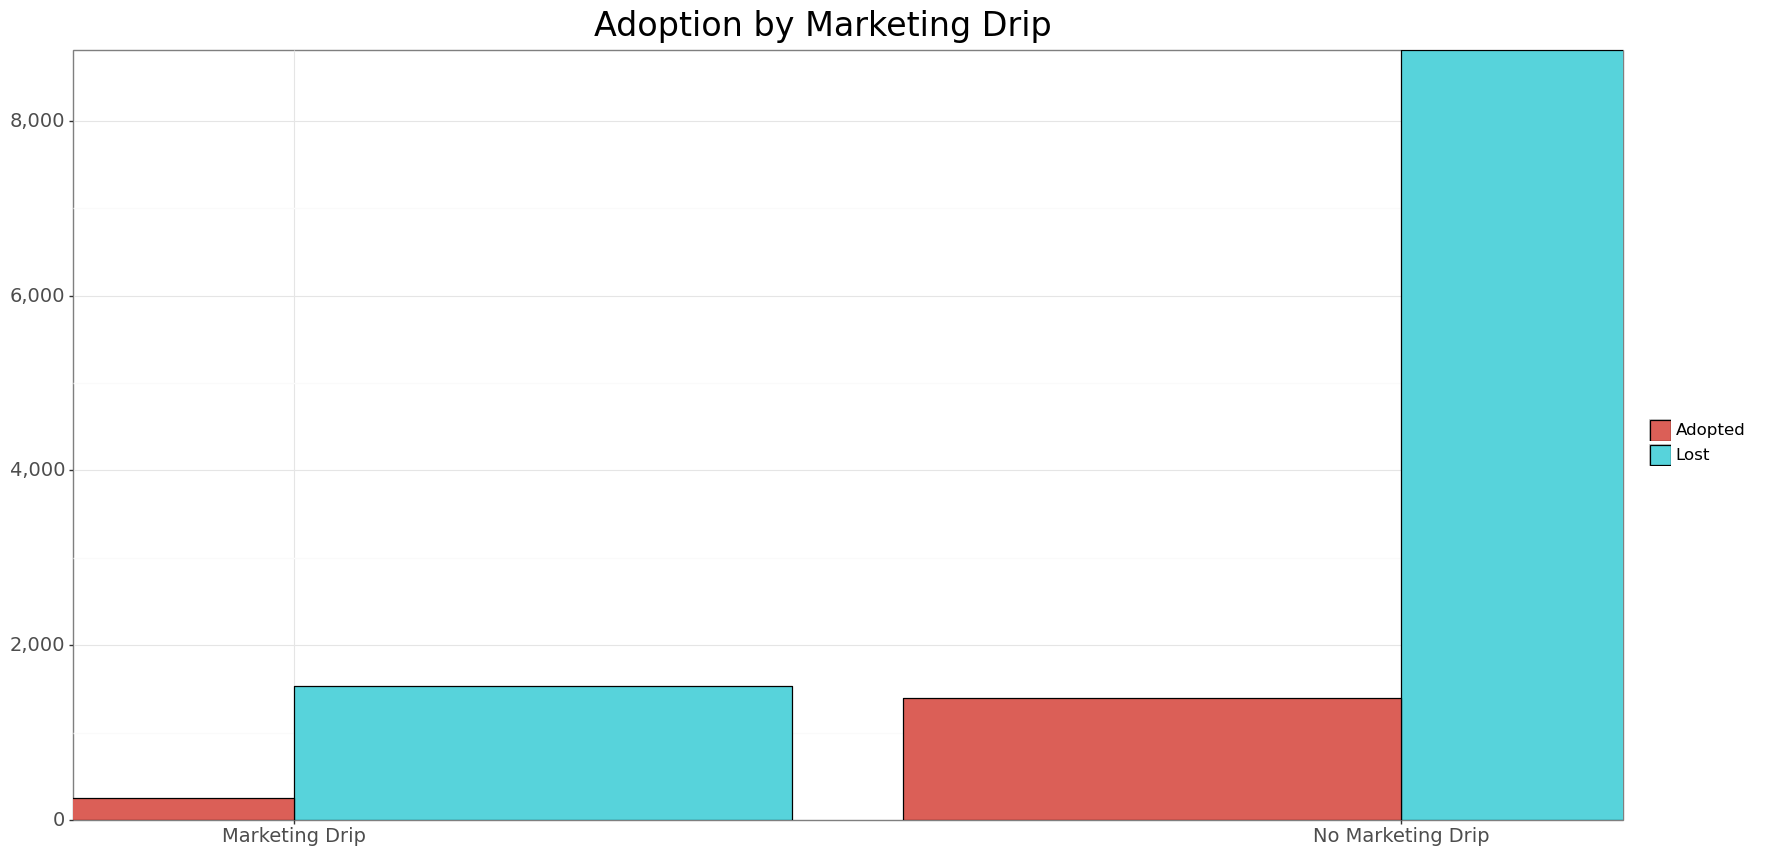

<ggplot: (132598741607)>

In [17]:
marketing_df =  pd.DataFrame(users_df[["adoption", "enabled_for_marketing_drip"]].value_counts()).\
reset_index().\
assign(adoption = lambda x: x.adoption.apply(lambda y: "Adopted" if y == 1 else "Lost"), 
       enabled_for_marketing_drip = lambda x: x.enabled_for_marketing_drip.apply(lambda y: "Marketing Drip" if y == 1 else "No Marketing Drip")).\
rename(columns = {0 : "count"})

(ggplot(marketing_df, aes(x = "enabled_for_marketing_drip", y = "count", fill = "adoption")) + 
 geom_bar(stat = "identity", position = "dodge", color = "black") + 
 scale_x_discrete(expand = [.1,  .1]) + 
 scale_y_continuous(labels = comma_format(), expand = [0, 0]) +
 labs(title = "Adoption by Marketing Drip", 
     x = "", 
     y = "", 
     fill = "") + 
 theme_bw() + 
 theme(axis_text_x = element_text(size = 14), 
       axis_text_y = element_text(size = 14), 
       legend_text = element_text(size = 12), 
       legend_title = element_text(size = 14), 
       plot_title = element_text(size = 24)))

Adoption rates look about the same regarless of whether or not the user signed up for marketing email drip

## Account Days

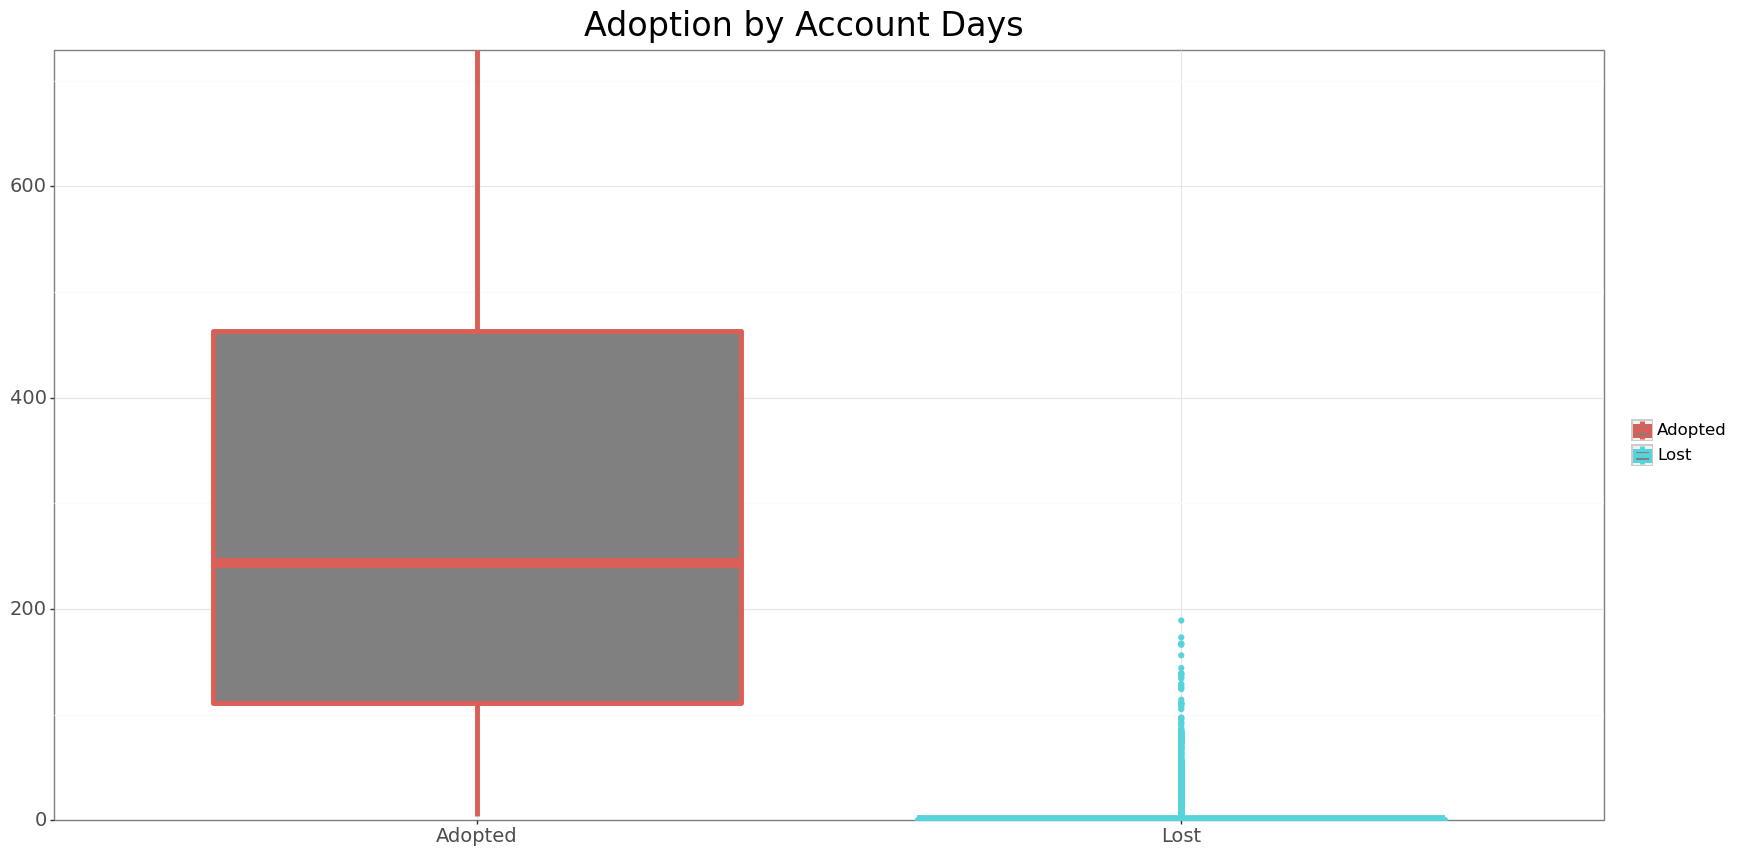

<ggplot: (132599714801)>

In [18]:
account_days_df = users_df[["adoption", "account_days"]].\
assign(adoption = lambda x: x.adoption.apply(lambda y: "Adopted" if y == 1 else "Lost"))

(ggplot(account_days_df, aes(x = "adoption", y = "account_days", color = "adoption")) + 
 geom_boxplot(fill = "grey", size = 2) + 
 scale_y_continuous(labels = comma_format(), expand = [0, 0]) +
 labs(title = "Adoption by Account Days", 
     x = "", 
     y = "", 
     color = "") + 
 theme_bw() + 
 theme(axis_text_x = element_text(size = 14), 
       axis_text_y = element_text(size = 14), 
       legend_text = element_text(size = 12), 
       legend_title = element_text(size = 14), 
       plot_title = element_text(size = 24)))

There is a HUGE differnce in number of active account days between adopted users and lost users

## Correlation

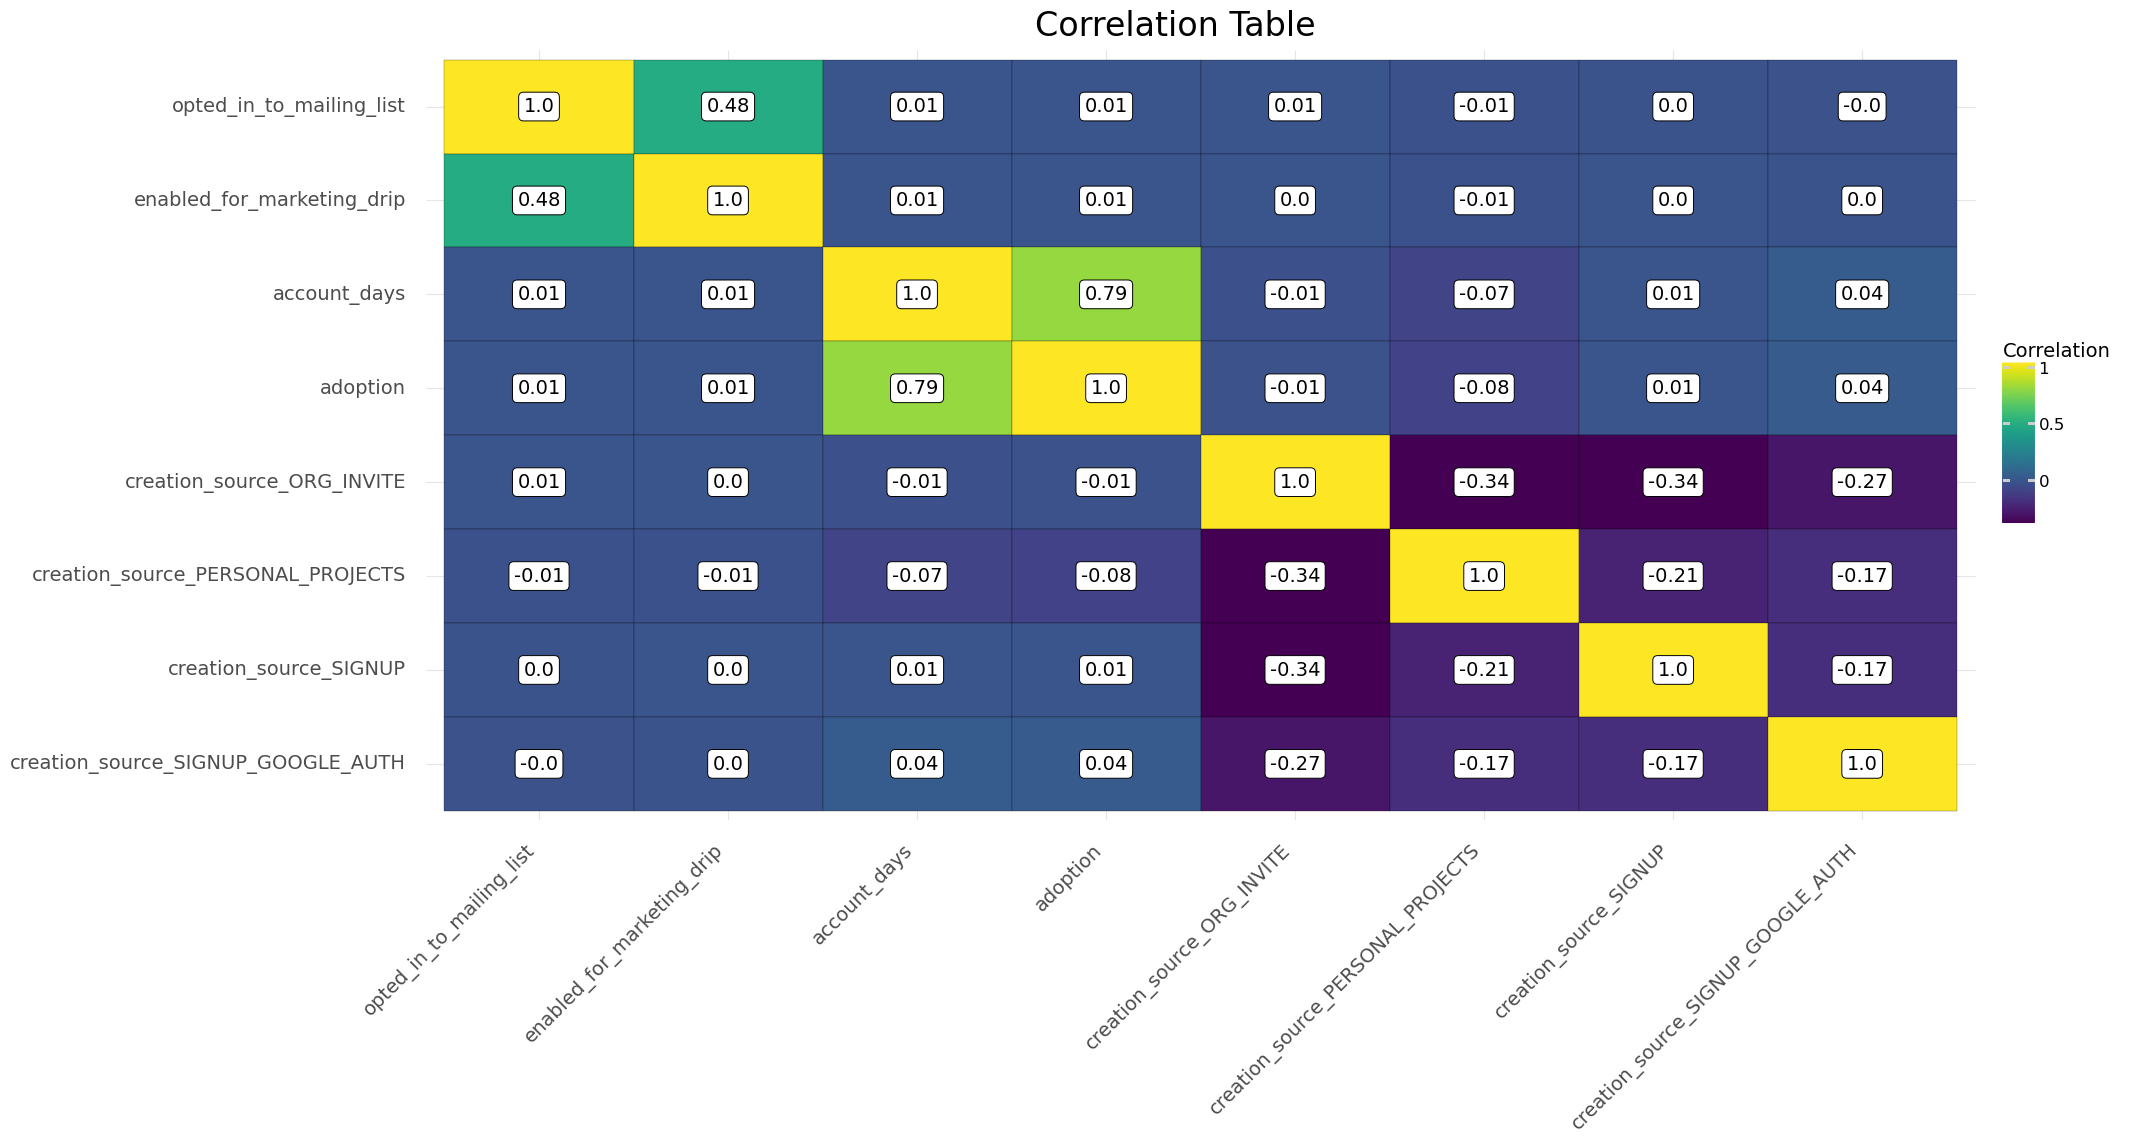

<ggplot: (132601621474)>

In [19]:
# Creating dummy variables for correlation table and for use in model creation later
users_df = pd.get_dummies(users_df, columns = ["creation_source"], drop_first = True)

users_df_corr = users_df.corr().\
melt(ignore_index = False).\
reset_index().\
set_axis(labels = ["var1", "var2", "value"], 
         axis = 1).\
assign(lab_text = lambda x: np.round(x.value, 2)).\
assign(var1 = lambda x: cat.cat_inorder(x.var1),
       var2 = lambda x: cat.cat_rev(cat.cat_inorder(x.var2)))

(ggplot(users_df_corr, aes(x = "var1", y = "var2", fill = "value", label = "lab_text")) + 
 geom_tile(color = "black") +
 geom_label(fill = "white", size = 14) + 
 labs(title = "Correlation Table", 
     x = "", 
     y = "", 
     fill = "Correlation") + 
 theme_minimal() + 
 theme(axis_text_x = element_text(size = 14, rotation = 45, hjust = 1), 
       axis_text_y = element_text(size = 14), 
       legend_text = element_text(size = 12), 
       legend_title = element_text(size = 14), 
       plot_title = element_text(size = 24)))

In [20]:
users_df.corr()[["adoption"]].\
assign(ish = lambda x: x.adoption.abs()).\
sort_values("ish", ascending = False).\
drop("adoption", axis = 0).\
adoption

account_days                          0.788421
creation_source_PERSONAL_PROJECTS    -0.075717
creation_source_SIGNUP_GOOGLE_AUTH    0.036198
creation_source_SIGNUP                0.008920
opted_in_to_mailing_list              0.008838
creation_source_ORG_INVITE           -0.006592
enabled_for_marketing_drip            0.006578
Name: adoption, dtype: float64

The only variable with any notable correlation to adoption rate is **account_dayys**. It's coeficient is 0.79 and the next highest is **creation_source_PERSONAL_PROJECTS** at -0.07

# Preprocessing

I'm changing the adoption variable to show labels **adopted/lost** for readability

In [21]:
users_df = users_df.assign(adoption = lambda x: x.adoption.apply(lambda y: "Adopted" if y == 1 else "Lost"))
users_df

,opted_in_to_mailing_list,enabled_for_marketing_drip,account_days,adoption,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
object_id,,,,,,,,
1,1,0,0,Lost,0,0,0,0
2,0,0,136,Adopted,1,0,0,0
3,0,0,0,Lost,1,0,0,0
4,0,0,1,Lost,0,0,0,0
5,0,0,5,Lost,0,0,0,0
...,...,...,...,...,...,...,...,...
11996,0,0,0,Lost,1,0,0,0
11997,0,0,5,Lost,0,0,0,1
11998,1,1,0,Lost,0,0,0,0


## Training & Test Set Split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(users_df.drop(columns = ["adoption"]), users_df.adoption, 
                                                    test_size = 0.3, random_state = 610)

going to scale variables for consistency. This really only affects the **account_days** variable as everything else is binary (0, 1)

In [23]:
X_train_scaled = pd.DataFrame(StandardScaler().fit_transform(X_train), columns = X_train.columns)
X_test_scaled = pd.DataFrame(StandardScaler().fit_transform(X_test), columns = X_test.columns)

In [29]:
X_train_scaled.info(verbose = True)
print("=================================================================")
y_train.info(verbose = True)
print("=================================================================")
X_test_scaled.info(verbose = True)
print("=================================================================")
y_test.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8400 entries, 0 to 8399
Data columns (total 7 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   opted_in_to_mailing_list            8400 non-null   float64
 1   enabled_for_marketing_drip          8400 non-null   float64
 2   account_days                        8400 non-null   float64
 3   creation_source_ORG_INVITE          8400 non-null   float64
 4   creation_source_PERSONAL_PROJECTS   8400 non-null   float64
 5   creation_source_SIGNUP              8400 non-null   float64
 6   creation_source_SIGNUP_GOOGLE_AUTH  8400 non-null   float64
dtypes: float64(7)
memory usage: 459.5 KB
<class 'pandas.core.series.Series'>
Int64Index: 8400 entries, 4065 to 973
Series name: adoption
Non-Null Count  Dtype 
--------------  ----- 
8400 non-null   object
dtypes: object(1)
memory usage: 131.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entri

# Modeling

## Hyperparameter Tuning

In [30]:
rand_for = RandomForestClassifier(n_jobs = -1, random_state = 610)

param_grid = {"n_estimators": np.arange(100, 600, 100), 
              #"criterion": ["gini", "entropy", "log_loss"],
              "criterion": ["gini"],
              "max_depth": [5, 10, 20, None],
              "bootstrap": [True, False]}

grid = GridSearchCV(rand_for, param_grid, cv = 5)

grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=610),
             param_grid={'bootstrap': [True, False], 'criterion': ['gini'],
                         'max_depth': [5, 10, 20, None],
                         'n_estimators': array([100, 200, 300, 400, 500])})

### Model Creation

In [31]:
rand_for = RandomForestClassifier(n_estimators = grid.best_estimator_.n_estimators,
                                  criterion = grid.best_estimator_.criterion,
                                  max_depth = grid.best_estimator_.max_depth, 
                                  bootstrap = grid.best_estimator_.bootstrap, 
                                  n_jobs = -1, 
                                  random_state = 610)

rand_for.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=610)

In [32]:
cv = KFold(n_splits = 10, random_state = 610, shuffle = True)
scores = cross_val_score(rand_for, X_train_scaled, y_train, cv = cv)
print("Cross Validation Mean Score: ", round(np.mean(scores), 4), " (Std: ", round(np.std(scores), 4), ")", sep = "")
print("Classification Report for Test Data")
print(classification_report(y_test, rand_for.predict(X_test_scaled)))

Cross Validation Mean Score: 0.9751 (Std: 0.0058)
Classification Report for Test Data
              precision    recall  f1-score   support

     Adopted       0.92      0.84      0.87       486
        Lost       0.97      0.99      0.98      3114

    accuracy                           0.97      3600
   macro avg       0.95      0.91      0.93      3600
weighted avg       0.97      0.97      0.97      3600



In [33]:
evaluation_metrics = pd.array(["model", "train_cv_mean", "train_cv_std", "accuracy", "precision", "recall", "f1"])

rand_for_evaluation = pd.array(["Random Forest", 
                               round(np.mean(scores), 4), 
                               round(np.std(scores), 4), 
                               round(accuracy_score(rand_for.predict(X_test_scaled), y_test), 4), 
                               round(precision_score(rand_for.predict(X_test_scaled), y_test, pos_label = "Adopted"), 4), 
                               round(recall_score(rand_for.predict(X_test_scaled), y_test, pos_label = "Adopted"), 4), 
                               round(f1_score(rand_for.predict(X_test_scaled), y_test, pos_label = "Adopted"), 4)])

rand_for_evaluation = pd.DataFrame(rand_for_evaluation, evaluation_metrics).transpose()
rand_for_evaluation

,model,train_cv_mean,train_cv_std,accuracy,precision,recall,f1
0,Random Forest,0.9751,0.0058,0.9675,0.8354,0.9165,0.8741


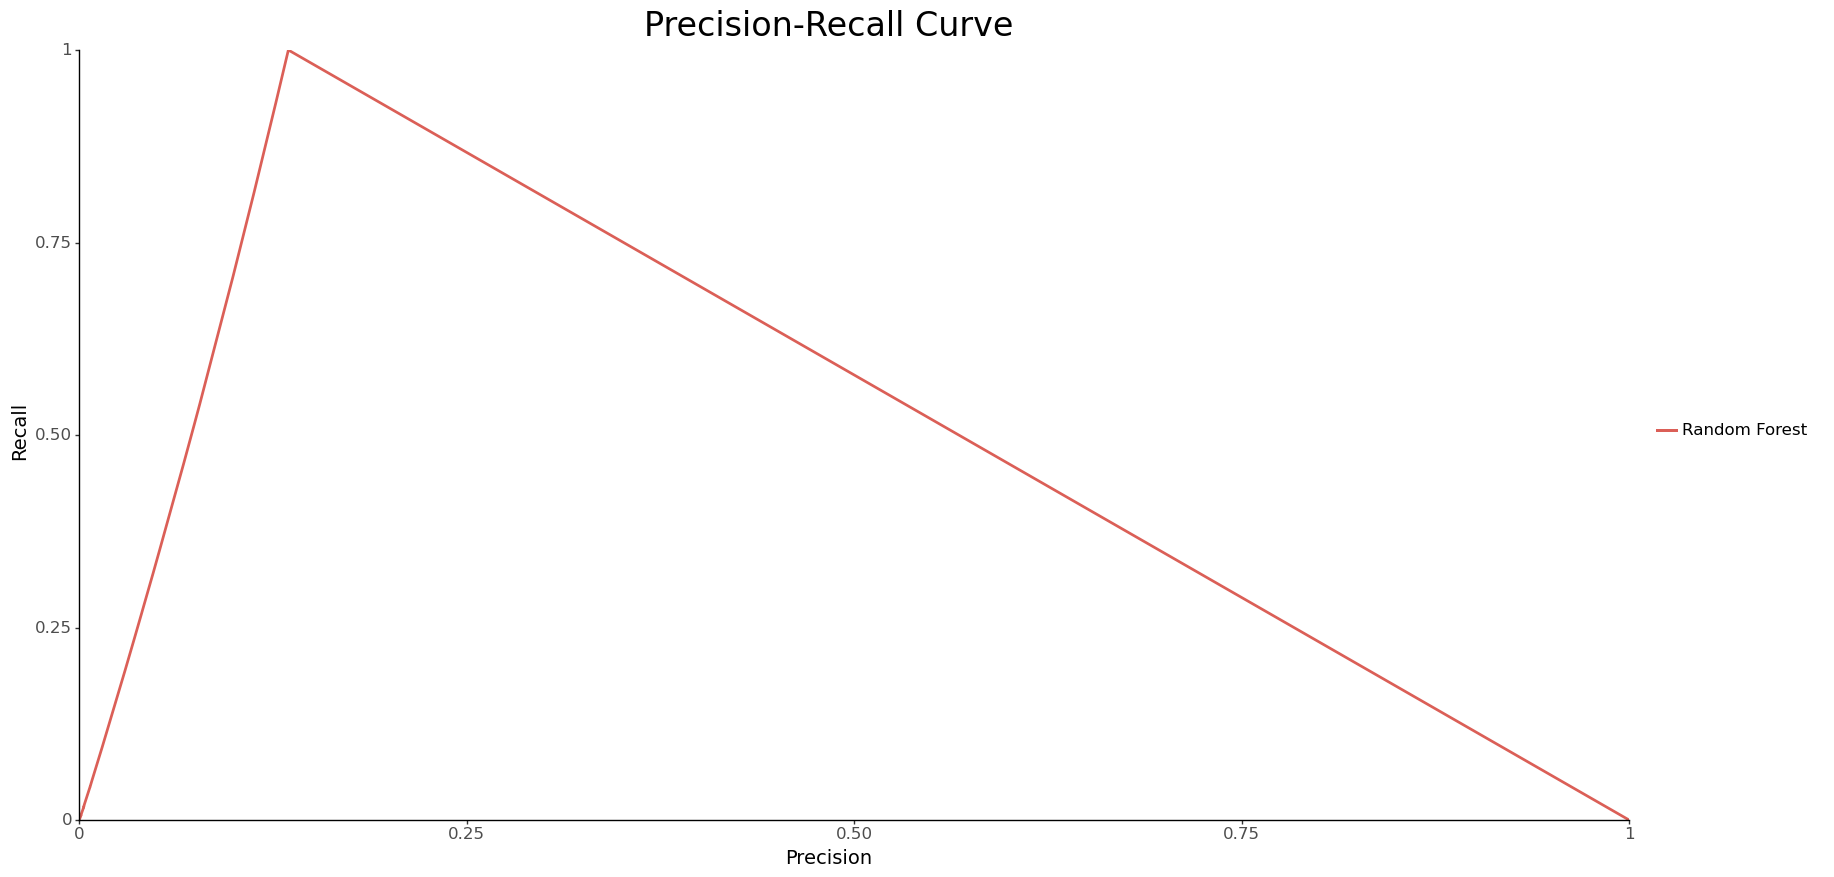

<ggplot: (132599693587)>

In [34]:
predicted_probs = rand_for.predict_proba(X_test_scaled)[:, 1]

precision, recall, thresholds  = precision_recall_curve(y_test, predicted_probs, pos_label = "Adopted")
thresholds = np.append(thresholds, 0)

pr_df = pd.DataFrame({"model": "Random Forest", 
                                 "precision":precision, 
                                 "recall":recall, 
                                 "thresholds":thresholds})


(ggplot(pr_df, aes(x = "precision", y = "recall", color = "model")) + 
 geom_line(size = 1.1) + 
 scale_x_continuous(expand = [0, 0]) + 
 scale_y_continuous(expand = [0, 0]) + 
 labs(title = "Precision-Recall Curve", 
      x = "Precision", 
      y = "Recall") + 
 theme_classic() +
 theme(axis_text = element_text(size = 12), 
       axis_title = element_text(size = 14),
       legend_position = "right",
       legend_text = element_text(size = 12),
       legend_title = element_blank(), 
       plot_title = element_text(size = 24)))

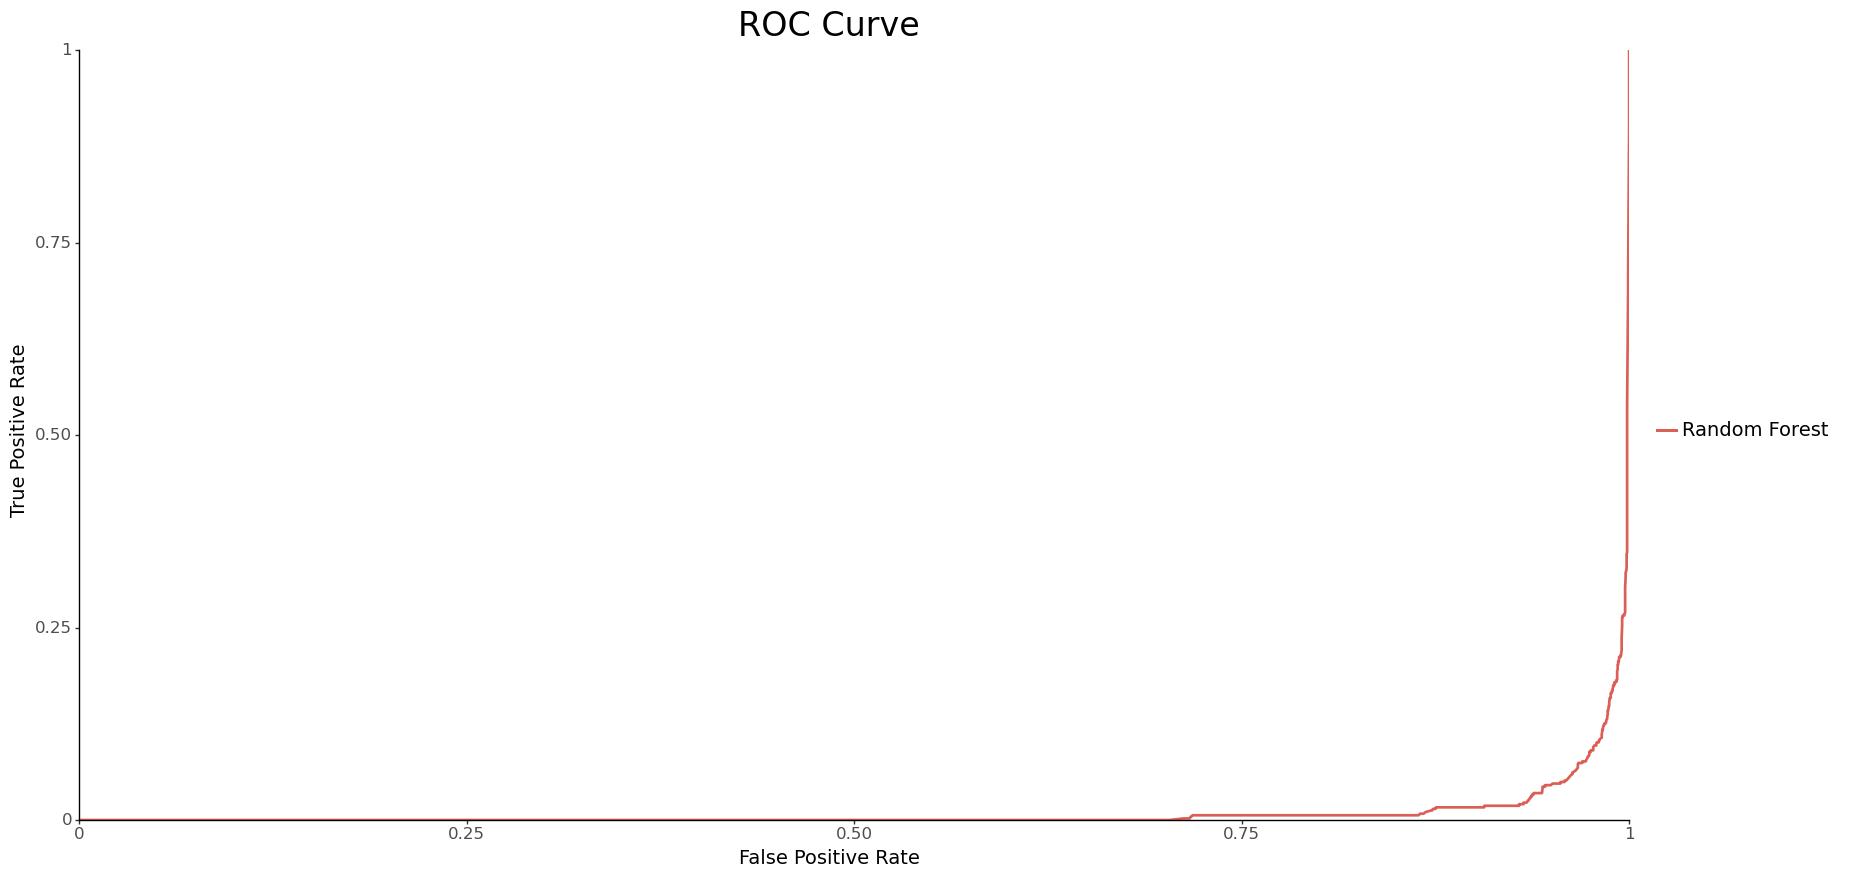

<ggplot: (132602049838)>

In [35]:
predicted_probs = rand_for.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds  = roc_curve(y_test, predicted_probs, pos_label = "Adopted")

roc_df = pd.DataFrame({"model": "Random Forest",
                       "auc": round(auc(fpr, tpr), 3).astype(str),
                       "fpr":fpr, 
                       "tpr":tpr, 
                       "thresholds":thresholds})


(ggplot(roc_df, aes(x = "fpr", y = "tpr", color = "model")) + 
 geom_line(size = 1.1) + 
 scale_x_continuous(expand = [0, 0]) + 
 scale_y_continuous(expand = [0, 0]) + 
 labs(title = "ROC Curve", 
      x = "False Positive Rate", 
      y = "True Positive Rate") + 
 theme_classic() +
 theme(axis_text = element_text(size = 12), 
       axis_title = element_text(size = 14), 
       legend_position = "right",
       legend_text = element_text(size = 14),
       legend_title = element_blank(), 
       plot_title = element_text(size = 24)))

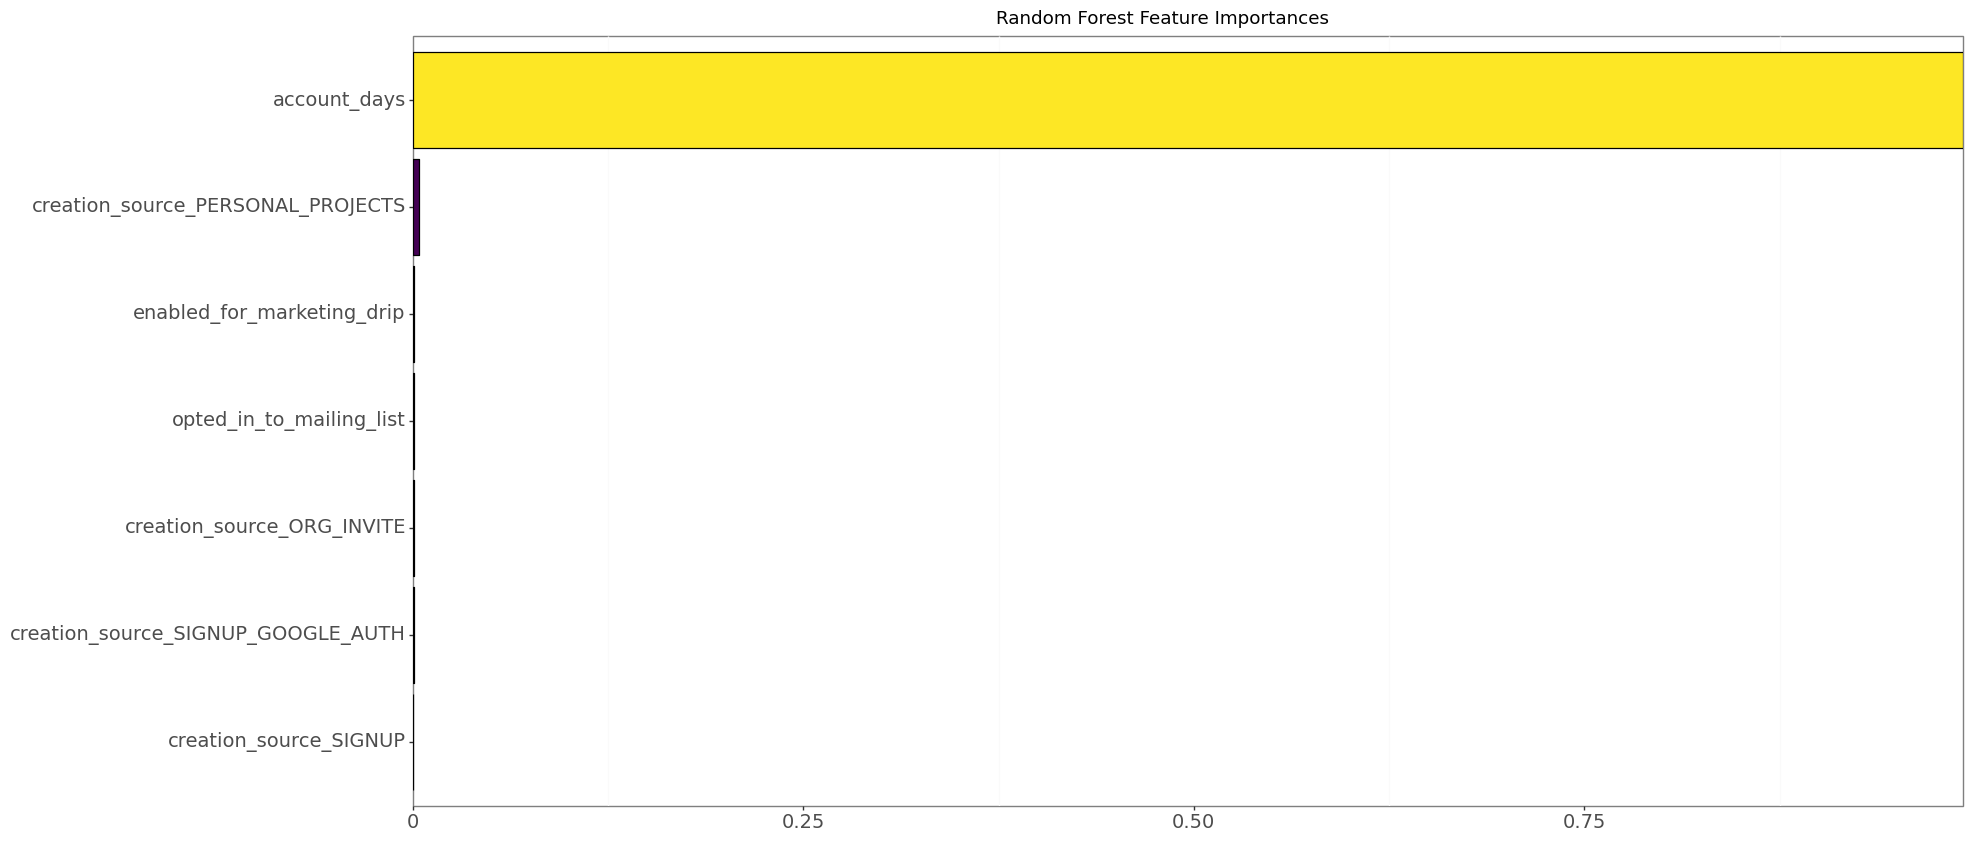

<ggplot: (132601673150)>

In [36]:
rand_for_features_df = pd.DataFrame({"importance": pd.Series(rand_for.feature_importances_, index = rand_for.feature_names_in_)}).\
reset_index().\
rename(columns = {"index" : "feature"}).\
assign(feature = lambda x: x.feature.astype("category").cat.reorder_categories(x.set_index("feature").sort_values("importance").index.tolist()))


(ggplot(rand_for_features_df, aes(x = "feature", y = "importance", fill = "importance")) + 
 geom_bar(stat = "identity", color = "black") + 
 coord_flip() + 
 scale_y_continuous(expand = [0, 0])+ 
 labs(title = "Random Forest Feature Importances", 
      x = "", 
      y = "", 
      fill = "") + 
 theme_bw() + 
 theme(axis_text_x = element_text(size = 14), 
       axis_text_y = element_text(size = 14), 
       legend_position = "none",
       panel_grid_major = element_blank()))

I was very confused by the Precision/Recall curve and ROC curve. I've never seen them shaped that way. I thought I may have made an error until I looked at the feature importance and had a realization. The **adoption** output variable was created based on the number of days an account was active. A user needs to log in 3 times within a 7-day period. So the longer an account is active for, the more likely that user just so happened to log in 3 times within some 7-day period. This relationship is so strong relative to the other variables that it makes them useless.

I decided to go with a random forest because I needed a classification model and it has generally worked out best for me in the past. However, looking at the results, logistic regression probably would have better solved this problem for its simplicity. The more days an account has been active, the more likely that user is adopted based on the given definition. It's possible the random forest would still be more accurate, but I would favor interpretability considering there's only really one input variable needed.